In [1]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing

from split_dataset import SplitDataset
from pathlib import Path
import pandas as pd 
import flammkuchen as fl

from bouter import EmbeddedExperiment

from matplotlib import pyplot as plt
import seaborn as sns

from skimage import io
import numpy as np 
from scipy import signal
import scipy.io 

from scipy.stats import zscore
from scipy.stats import sem

from scipy.interpolate import interp1d

import seaborn as sns
import json

from mpl_toolkits import mplot3d
%matplotlib widget

from skimage import measure

import networkx as nx
import matplotlib.gridspec as gridspec

import os
import numpy.ma as ma

import mypatterns as mpt

import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors

from nilearn.connectome import ConnectivityMeasure
from sklearn.manifold import SpectralEmbedding




In [2]:


# Utility functions: 
def plot_whole_brain_coordinates_scatter(xx,yy,zz):
    f, axs = plt.subplots(1, 2, figsize=(7, 3))
    axs[0].scatter(xx, yy, lw=0, s=5, alpha=0.03, color=(0.3,) * 3)
    axs[1].scatter(yy, -zz, lw=0, s=5, alpha=0.03, color=(0.3,) * 3)
    for i in range(2):
        # axs[i].set_title(k)
        axs[i].axis("equal")
        axs[i].axis("off")
    plt.show() 

def plot_whole_brain_coordinates(xx,yy,zz):
    f, axs = plt.subplots(1, 3, figsize=(15, 8))
    axs[2].hist2d(zz, yy, bins=250, cmap='hot')
    axs[1].hist2d(zz, xx, bins=150, cmap='hot')
    axs[0].hist2d(xx, yy, bins=150, cmap='hot')
    # plt.colorbar().set_label('Number of properties')
    f.suptitle("Zebrafish Whole Brain Coordinates", fontsize=17)
    f.text(0.5, 0.04, 'Longitude', ha='center',fontsize=17)
    f.text(0.04, 0.5, 'Latitude', va='center', rotation='vertical',fontsize=17)
    plt.show()


def plot_specific_trace(traces, neuron_id_list, time_range):
    fig, ax = plt.subplots(len(neuron_id_list),1, sharex=True)
    sampling_rate = 300
    time_indx = np.arange(time_range)
    time_arr = time_indx/sampling_rate
    for i, a in enumerate(ax):
        neuron_id = neuron_id_list[i]
        a.plot(time_arr, traces[neuron_id, time_indx])
    sns.despine(left=True, bottom=True, right=True)
    plt.show()


def plot_connectivity_matrix(A, ax=None):
  """Plot the (weighted) connectivity matrix A as a heatmap

    Args:
      A (ndarray): connectivity matrix (n_neurons by n_neurons)
      ax: axis on which to display connectivity matrix
  """
  if ax is None:
    ax = plt.gca()
  lim = np.abs(A).max()
  im = ax.imshow(A, vmin=-lim, vmax=lim, cmap="coolwarm")
  ax.tick_params(labelsize=10)
  ax.xaxis.label.set_size(15)
  ax.yaxis.label.set_size(15)
  cbar = ax.figure.colorbar(im, ax=ax, ticks=[0], shrink=.7)
  cbar.ax.set_ylabel("Connectivity Strength", rotation=90,
                     labelpad= 20, va="bottom")
  ax.set(xlabel="Connectivity from", ylabel="Connectivity to")

In [3]:
# Setup the paths:
fish_id = "220221_f0"
master_path = Path(r"Z:\Shared\experiments\E0040_motions_cardinal\v21\ls\h2b_wb")
data_path = master_path / fish_id
traces_path = data_path / "data_from_suite2p_cells.h5"


import h5py
filename = traces_path
with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())

    # Get the relevant group keys
    traces_group_key = 'traces'
    coords_group_key = 'coords'

    # get the object type for a_group_key: usually group or dataset
    print(type(f[traces_group_key]))
    print(type(f[coords_group_key]))  

    # If a_group_key is a group name, 
    # this gets the object names in the group and returns as a list
    data = list(f[traces_group_key])

    # If a_group_key is a dataset name, 
    # this gets the dataset values and returns as a list
    data = list(f[traces_group_key])
    
    # preferred methods to get dataset values:
    # ds_obj = f[a_group_key]      # returns as a h5py dataset object
    trace_all = f[traces_group_key][()]  # returns as a numpy array
    ROIs_all = f[coords_group_key][()]  # returns as a numpy array


# Data and Results paths
# path_name = 
# data_path = master_path / fish_id
# master_path_morphed = Path(r"Z:\Shared\experiments\E0030_long_term_adaptation\markovetal_supp\wholebrain_adaptation\files from RP")
# traces_path = master_path_morphed / "traces"
# rois_path = Path(r"Z:\Shared\experiments\E0030_long_term_adaptation\markovetal_supp\wholebrain_adaptation\barcodes_for_LP\ROI_centroids")



Keys: <KeysViewHDF5 ['anatomy_stack', 'areas', 'coords', 'rois_stack', 'suite2p_idxs', 'traces']>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>


In [4]:
# Getting time-courses and ROI locations
# trace_all = scipy.io.loadmat(next(traces_path.glob(fish_id +'*')))
# ROIs_all = scipy.io.loadmat(next(rois_path.glob(fish_id +'*')))

In [5]:
ROIs_all

array([[  0.        ,  80.98387097, 434.66129032],
       [  0.        ,  95.84615385, 485.38461538],
       [  0.        , 120.77464789, 496.36619718],
       ...,
       [ 14.        , 203.15533981, 528.77669903],
       [ 14.        , 198.09090909, 512.3030303 ],
       [ 14.        , 380.83870968, 528.93548387]])

In [6]:

# This is mainly to get scanning frequency and lag condition

with open(next(data_path.glob("*metadata.json")), "r") as f:
    metadata = json.load(f)
    
zf = metadata["imaging"]["microscope_config"]["lightsheet"]["scanning"]["z"]["frequency"]


protocol_params = metadata["stimulus"]["protocol"]["E0040_motions_cardinal"]["v20_cl_gainmod"]
# protocol_params["lag"]
    


In [7]:
data

[array([14.663998, 16.286428, 22.09066 , ...,  9.237096,  9.652163,
        10.471782], dtype=float32),
 array([15.327171, 16.34539 , 16.820847, ..., 10.414792,  9.547742,
         7.080974], dtype=float32),
 array([7.8647156, 5.8232136, 6.5636525, ..., 6.712644 , 6.34846  ,
        7.306004 ], dtype=float32),
 array([ 9.001839 ,  7.315307 ,  5.4595466, ..., 20.046299 , 20.9563   ,
        20.790854 ], dtype=float32),
 array([12.945268, 15.792767, 18.365244, ..., 15.707522, 12.307929,
        12.594048], dtype=float32),
 array([ 9.351032 , 10.758054 , 13.269953 , ..., 15.8796015, 15.00102  ,
        14.252086 ], dtype=float32),
 array([10.027822 , 13.333947 , 12.017998 , ...,  8.113759 ,  4.6306825,
         5.14703  ], dtype=float32),
 array([ 7.9366784,  8.3382845, 10.295423 , ...,  8.10855  ,  8.430899 ,
         8.362611 ], dtype=float32),
 array([10.384934,  8.749596,  9.681262, ..., 14.036031, 12.477072,
        11.882829], dtype=float32),
 array([ 9.666929, 11.262296, 11.180664,

In [8]:
# get time-course traces and Preprocessing

# TC = trace_all['traces']

nantest = np.sum(trace_all,axis = -1)
TC = np.squeeze(trace_all[np.argwhere(~np.isnan(nantest)),:])

fc_baseline=1/300  # Hz, 5 min period
TC=mpt.clean(TC, sampling_frq = zf, highpass = fc_baseline)


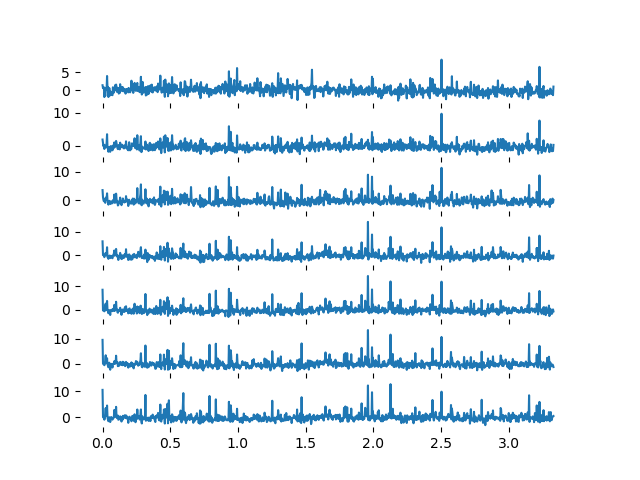

In [9]:

    
plot_specific_trace(TC, list(range(7)),1000)

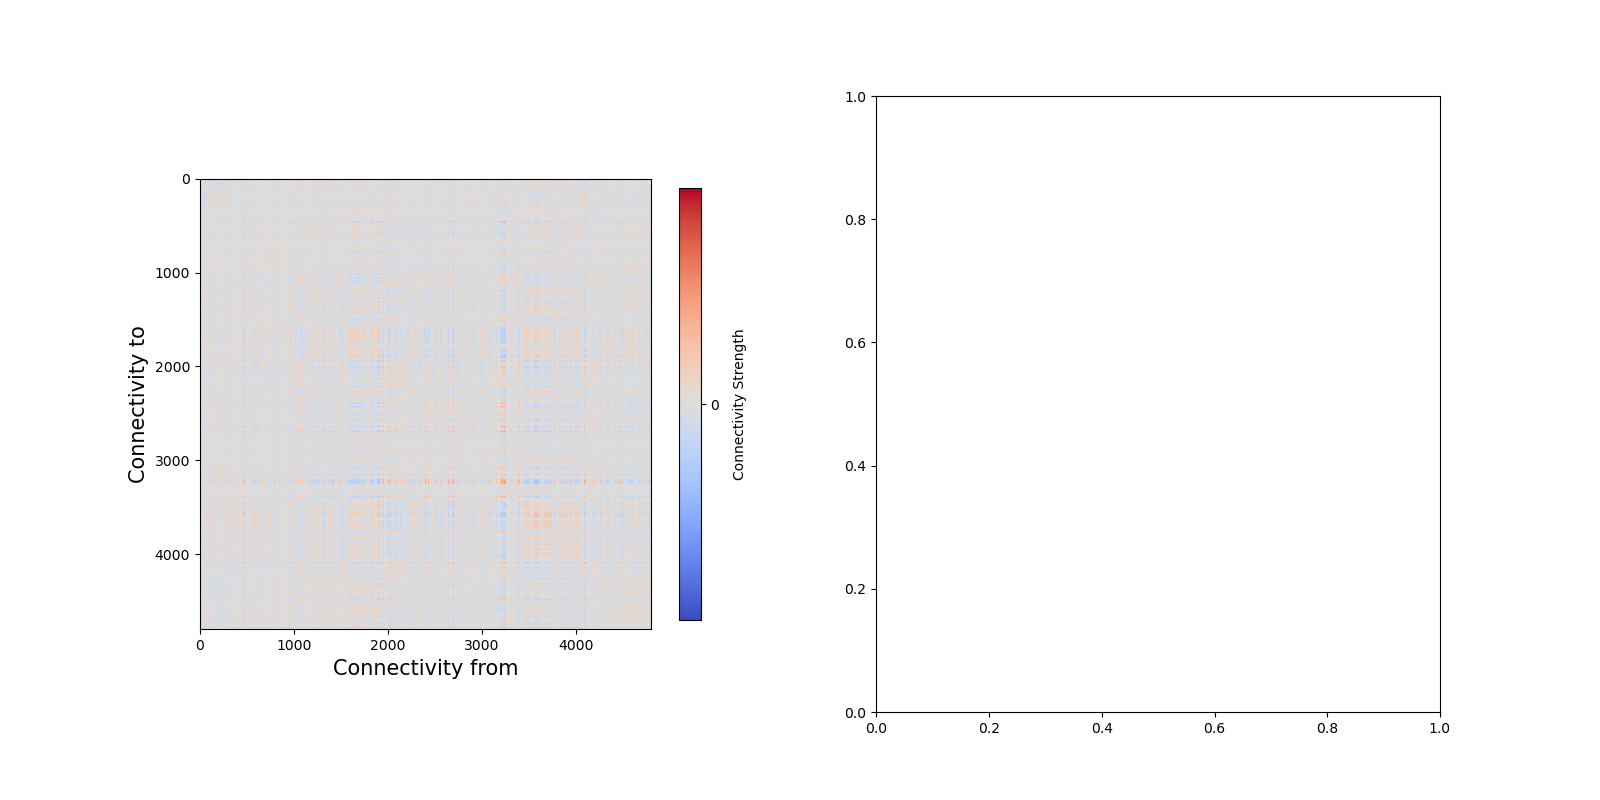

In [53]:
def correlation_for_all_neurons(X):
  """Computes the connectivity matrix for the all neurons using correlations
    Args:
        X: the matrix of activities
    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
  """
  n_neurons = len(X)
  S = np.concatenate([X[:, 1:], X[:, :-1]], axis=0)
  R = np.corrcoef(S)[:n_neurons, n_neurons:]
  return R

def plot_connectivity_matrix(A, ax=None):
  """Plot the (weighted) connectivity matrix A as a heatmap
    Args:
      A (ndarray): connectivity matrix (n_neurons by n_neurons)
      ax: axis on which to display connectivity matrix
  """
  if ax is None:
    ax = plt.gca()
  lim = np.abs(A).max()
  im = ax.imshow(A, vmin=-lim, vmax=lim, cmap="coolwarm")
  ax.tick_params(labelsize=10)
  ax.xaxis.label.set_size(15)
  ax.yaxis.label.set_size(15)
  cbar = ax.figure.colorbar(im, ax=ax, ticks=[0], shrink=.7)
  cbar.ax.set_ylabel("Connectivity Strength", rotation=90,
                     labelpad= 20, va="bottom")
  ax.set(xlabel="Connectivity from", ylabel="Connectivity to")

R = correlation_for_all_neurons(TC)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plot_connectivity_matrix(R, ax=axs[0])


In [52]:
# Extract z_resolution
import json
from pathlib import Path

dir_path = data_path
with open(next(Path(dir_path).glob("*metadata.json")), "r") as f:
        metadata = json.load(f)
lsconfig = metadata["imaging"]["microscope_config"]['lightsheet']['scanning']
z_tot_span = lsconfig["z"]["piezo_max"] - lsconfig["z"]["piezo_min"]
n_planes = lsconfig["triggering"]["n_planes"]
z_res = z_tot_span / n_planes




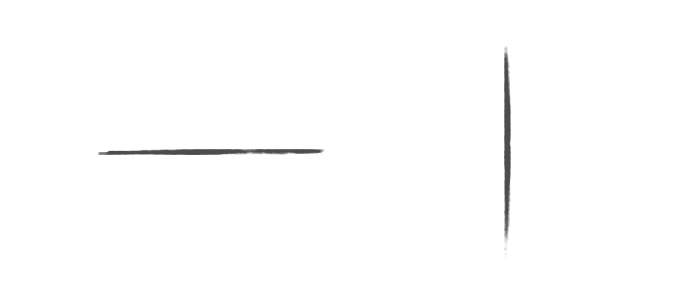

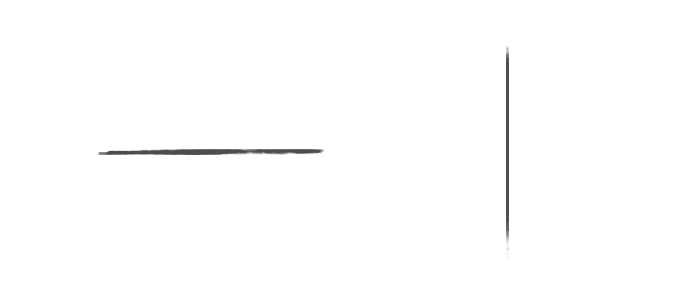

In [51]:
# Coordinates
# Before
XYZ = ROIs_all

# Correct rows by swapping using advanced indices (1,2,0)
XYZ[:,[0, 1]] = XYZ[:,[1, 0]]
XYZ[:,[2, 1]] = XYZ[:,[1, 2]]

XYZ = np.squeeze(XYZ[np.argwhere(~np.isnan(nantest)),:])
xx =  np.squeeze(XYZ[:,0])
yy =  np.squeeze(XYZ[:,1])
zz = np.squeeze(XYZ[:,2])
plt.title('After')
plot_whole_brain_coordinates_scatter(xx,yy,zz)


# XYZ = ROIs_all['ROI_centroids']
XYZ[:,0] *= 0.6
XYZ[:,1] *= 0.6
XYZ[:,2] *= z_res
XYZ = np.squeeze(XYZ[np.argwhere(~np.isnan(nantest)),:])
xx =  np.squeeze(XYZ[:,0])
yy =  np.squeeze(XYZ[:,1])
zz = np.squeeze(XYZ[:,2]) 
plt.title('After')
plot_whole_brain_coordinates_scatter(xx,yy,zz)




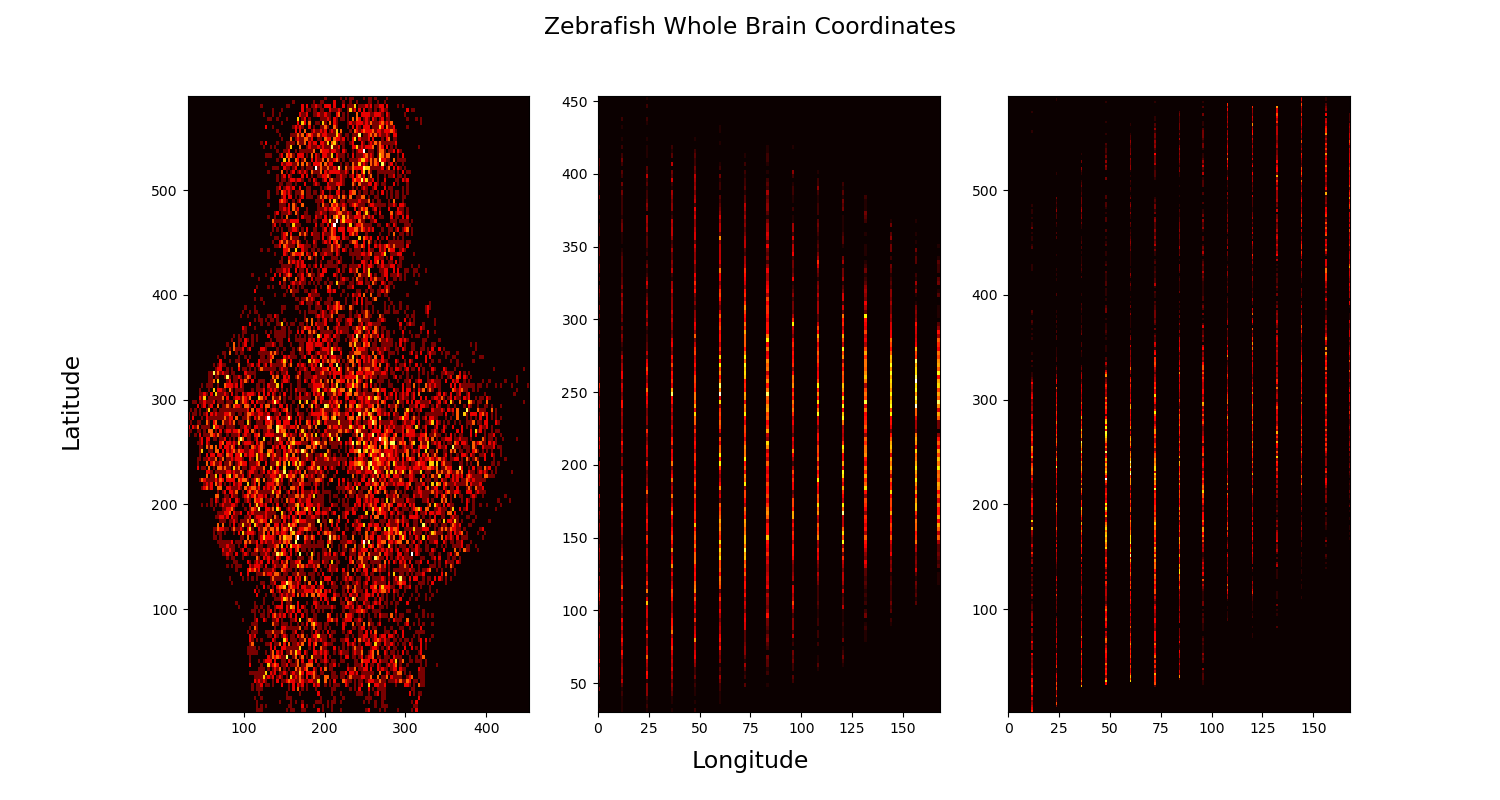

In [50]:
def plot_whole_brain_coordinates(xx,yy,zz):
    f, axs = plt.subplots(1, 3, figsize=(15, 8))
    axs[2].hist2d(zz, yy, bins=250, cmap='hot')
    axs[1].hist2d(zz, xx, bins=150, cmap='hot')
    axs[0].hist2d(xx, yy, bins=150, cmap='hot')
    # plt.colorbar().set_label('Number of properties')
    f.suptitle("Zebrafish Whole Brain Coordinates", fontsize=17)
    f.text(0.5, 0.04, 'Longitude', ha='center',fontsize=17)
    f.text(0.04, 0.5, 'Latitude', va='center', rotation='vertical',fontsize=17)
    plt.show()
plot_whole_brain_coordinates(xx,yy,zz)

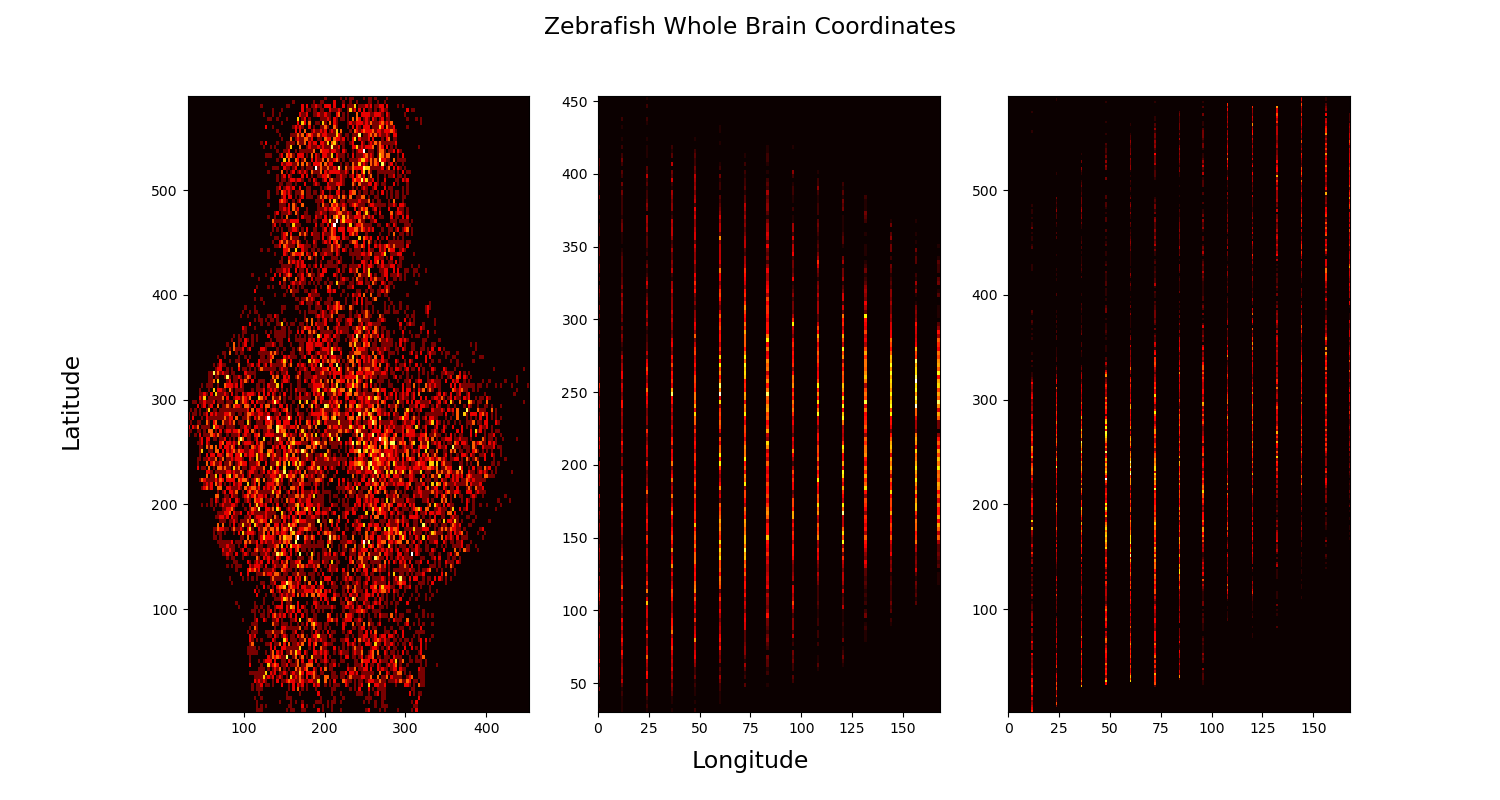

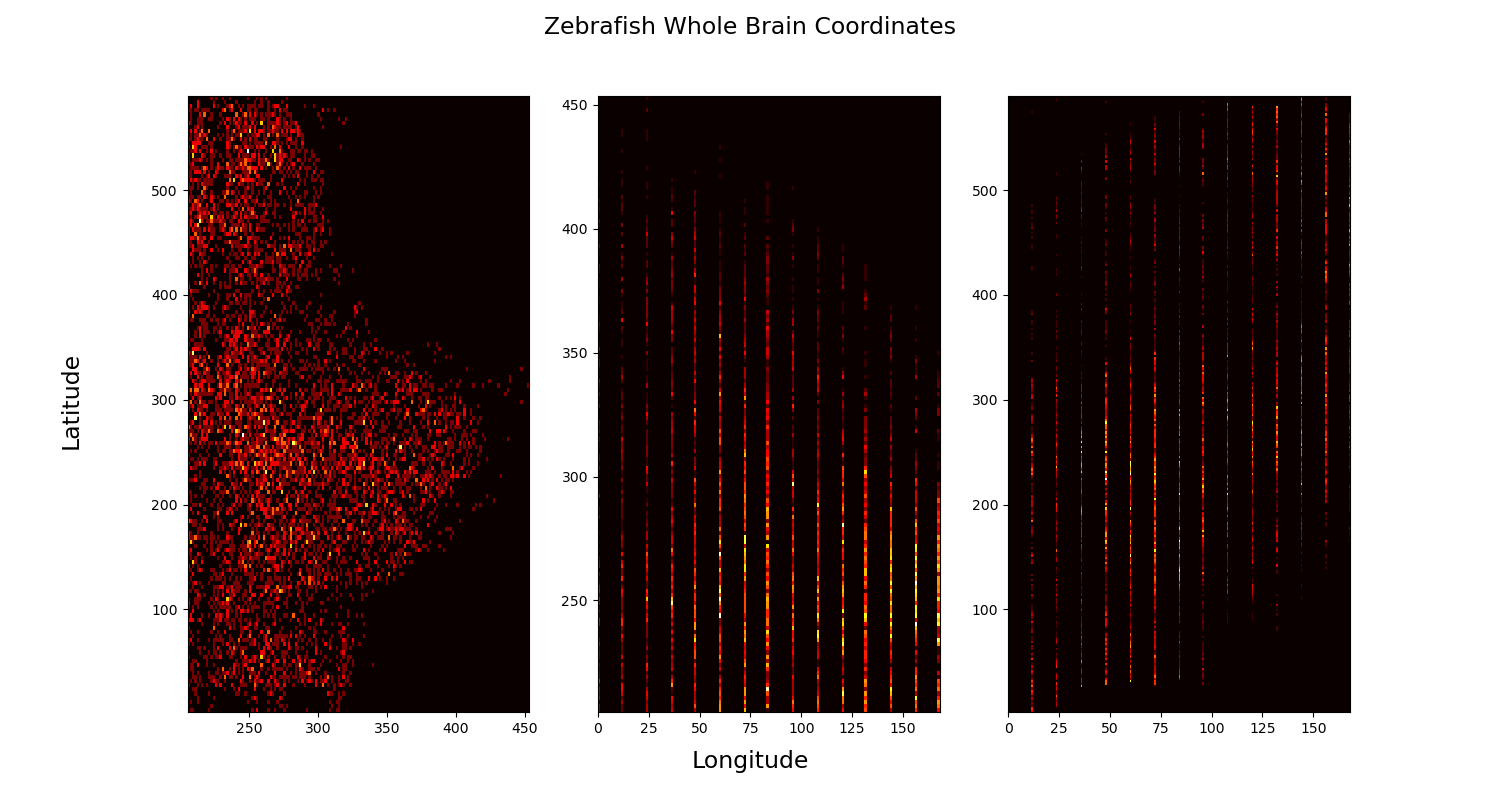

In [14]:
# Before
plot_whole_brain_coordinates(xx,yy,zz)

# After

# Parameters
hf = 205
sep = 60

# Extract L 
L=np.argwhere(xx>hf)
XYZL = np.squeeze(XYZ[L,:])
lxx =  np.squeeze(XYZL[:,0])
lyy =  np.squeeze(XYZL[:,1])
lzz = np.squeeze(XYZL[:,2])
plot_whole_brain_coordinates(lxx,lyy,lzz)


# Find centers
nClus = 100
clusterer = KMeans(n_clusters=nClus, random_state=0)
cluster_labels = clusterer.fit_predict(XYZL)
centers = clusterer.cluster_centers_
L_centers = centers

lxx =  np.squeeze(L_centers[:,0])
lyy =  np.squeeze(L_centers[:,1])
lzz = np.squeeze(L_centers[:,2])
rxx =  max(lxx) -  lxx + hf/2 - sep
ryy = lyy
rzz = lzz
R_centers = np.hstack((rxx.reshape(nClus,1),ryy.reshape(nClus,1),rzz.reshape(nClus,1)))



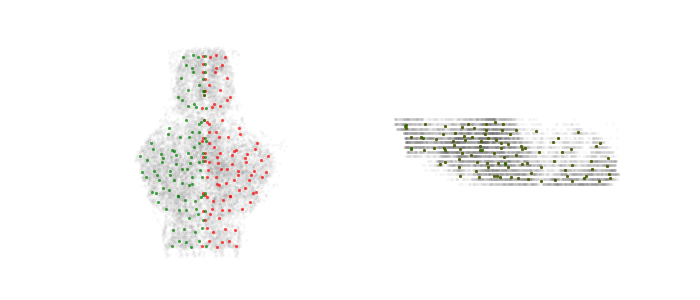

In [15]:
plt.close('all') 
plt.clf 

f, axs = plt.subplots(1, 2, figsize=(7, 3))


axs[0].scatter(xx, yy, lw=0, s=5, alpha=0.03, color=(0.3,) * 3)
axs[0].scatter(lxx, lyy, lw=0, s=5, alpha=0.7, color='r')
axs[0].scatter(rxx, ryy, lw=0, s=5, alpha=0.7, color= 'g')


axs[1].scatter(yy, -zz, lw=0, s=5, alpha=0.03, color=(0.3,) * 3)
axs[1].scatter(lyy, -lzz, lw=0, s=5, alpha=0.7, color='r')
axs[1].scatter(ryy, -rzz, lw=0, s=5, alpha=0.7, color='g')

    
for i in range(2):
    # axs[i].set_title(k)
    axs[i].axis("equal")
    axs[i].axis("off")
plt.show() 


In [16]:
LR_centers = np.concatenate((L_centers, R_centers))

X = np.array(LR_centers)
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(XYZ)

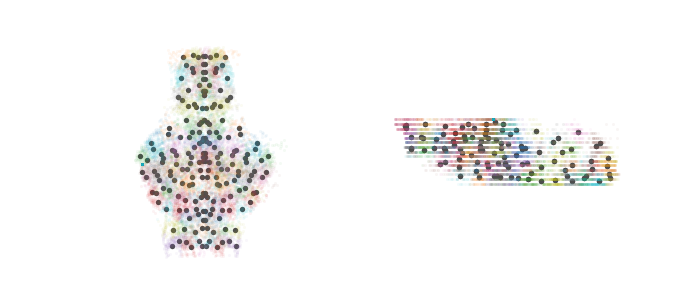

In [17]:
plt.close('all') 
plt.clf 

f, axs = plt.subplots(1, 2, figsize=(7, 3))


axs[0].scatter(lxx, lyy, lw=0, s=15, alpha=1,  color=(0.3,) * 3)
axs[0].scatter(rxx, ryy, lw=0, s=15, alpha=1,  color=(0.3,) * 3)


axs[1].scatter(lyy, -lzz, lw=0, s=15, alpha=1,  color=(0.3,) * 3)
axs[1].scatter(ryy, -rzz, lw=0, s=15, alpha=1, color=(0.3,) * 3)

for c in range(2*nClus):
    sub_ind = np.argwhere(indices==c) 
    
    axs[0].scatter(xx[sub_ind], yy[sub_ind], lw=0, s=5, alpha=0.05)


    axs[1].scatter(yy[sub_ind], -zz[sub_ind], lw=0, s=5, alpha=0.05)
    
    

for i in range(2):
    # axs[i].set_title(k)
    axs[i].axis("equal")
    axs[i].axis("off")
    
plt.show() 


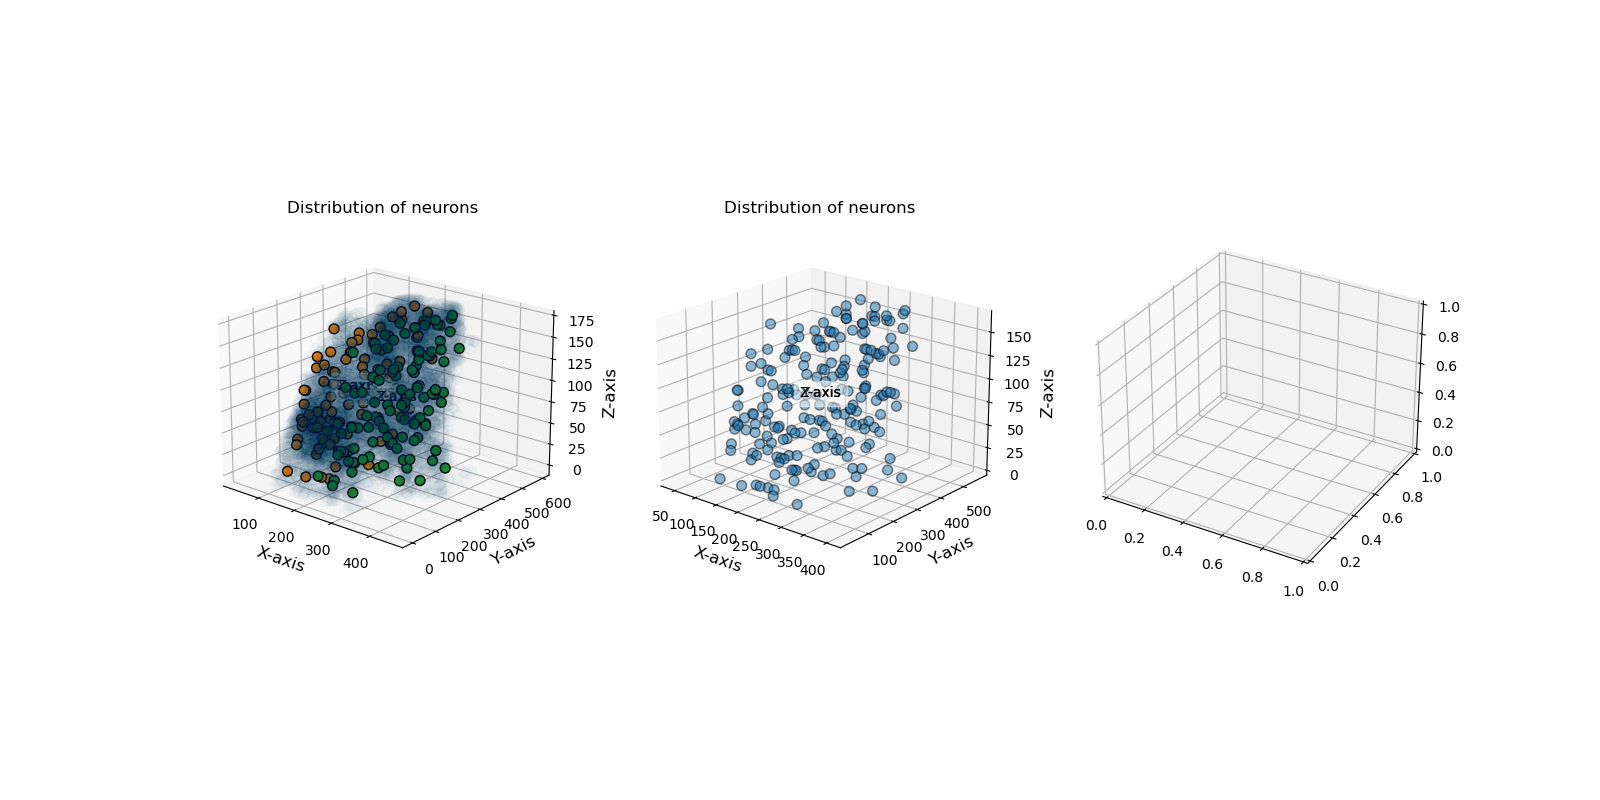

In [18]:

def plot_3d_projection(XYZ, ax=None, dot_size=100, transparency=0.5):
    if ax is None:
        ax = plt.gca()
    names = ['X-axis','Y-axis','Z-axis']
    for label, name in enumerate(names):
        ax.text3D(
            XYZ[:, 0].mean(),
            XYZ[:, 1].mean(),
            XYZ[:, 2].mean() + 2,
            name,
            horizontalalignment="center",
            bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
        )
    ax.scatter(XYZ[:, 0], XYZ[:, 1], XYZ[:, 2], 
                edgecolor="k", s=dot_size, 
                cmap='viridis', alpha=transparency)
    ax.view_init(20, -50)
    ax.set_xlabel(names[0], fontsize=12)
    ax.set_ylabel(names[1], fontsize=12)
    ax.set_zlabel(names[2], fontsize=12)
    ax.set_title("Distribution of neurons", fontsize=12)

fig, axs = plt.subplots(1, 3, figsize=(16, 8), subplot_kw=dict(projection='3d'))
plot_3d_projection(XYZ, ax=axs[0],dot_size=50,transparency=0.015)
plot_3d_projection(LR_centers, ax=axs[1],dot_size=50)
plot_3d_projection(R_centers, ax=axs[0],dot_size=50, transparency=1)
plot_3d_projection(L_centers, ax=axs[0],dot_size=50, transparency=1)
# plot_3d_projection(R_centers, ax=axs[0], transparency=1)
# plot_3d_projection([rxx,ryy,rzz], ax=axs[0], transparency=1)
# ax2 = plt.axes(projection='3d')


In [19]:
N=2*nClus
T = TC.shape[0]
M_all = np.empty((T,N))

for c in range(N):
    sub_ind = np.squeeze(np.argwhere(indices==c)[:,0])
    if np.size(sub_ind) > 1:
        M_all[:,c] =  np.nanmean(TC[:,sub_ind],axis=1)
    elif np.size(sub_ind) == 1:
         M_all[:,c] =  TC[:,sub_ind]



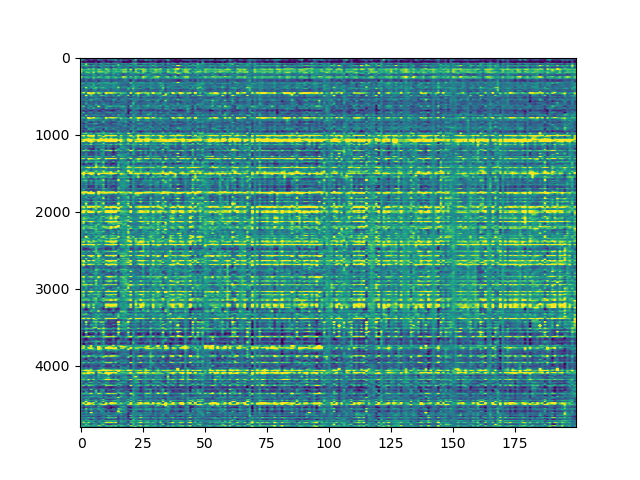

In [20]:
plt.close('all') 
plt.clf 

plt.imshow(M_all, aspect='auto',vmin = -1, vmax = 1)


In [21]:
data = M_all.T

In [22]:
import numpy as np
def DMD(data, r):
    """Dynamic Mode Decomposition (DMD) algorithm."""
    
    ## Build data matrices
    X1 = data[:, : -1]
    X2 = data[:, 1 :]
    ## Perform singular value decomposition on X1
    u, s, v = np.linalg.svd(X1, full_matrices = False)
    ## Compute the Koopman matrix
    A_tilde = u[:, : r].conj().T @ X2 @ v[: r, :].conj().T * np.reciprocal(s[: r])
    ## Perform eigenvalue decomposition on A_tilde
    Phi, Q = np.linalg.eig(A_tilde)
    ## Compute the coefficient matrix
    Psi = X2 @ v[: r, :].conj().T @ np.diag(np.reciprocal(s[: r])) @ Q
    A = Psi @ np.diag(Phi) @ np.linalg.pinv(Psi)
    
    return A_tilde, Phi, A, Psi 

In [23]:
A_tilde, Phi, A, Psi  =  DMD(data, 6)

In [24]:
.5/np.log(Phi.real)

#np.pi/np.arctan(Phi.imag/Phi.real)

array([-20.10650701, -20.10650701, -11.01871579, -11.01871579,
       -21.08208156, -16.39822165])

In [25]:
np.pi/np.arctan(Phi.imag/Phi.real)

C:\Users\micha\AppData\Local\Temp\ipykernel_28096\1348664566.py:1: RuntimeWarning: divide by zero encountered in true_divide
  np.pi/np.arctan(Phi.imag/Phi.real)


array([   59.23628219,   -59.23628219,  3510.04599623, -3510.04599623,
                  inf,            inf])

c:\Users\micha\Anaconda\envs\course_env\lib\site-packages\matplotlib\axes\_axes.py:4192: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


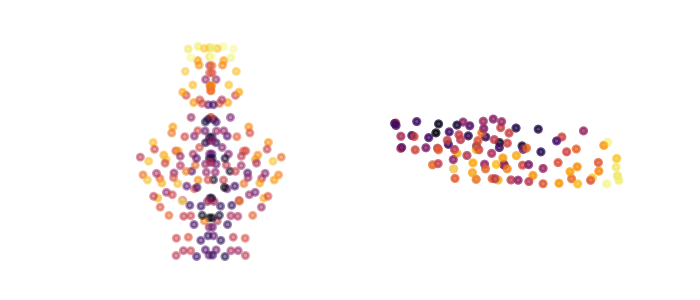

In [26]:
plt.close('all') 
plt.clf 


cplot =  np.empty((len(xx)))
cplot[:] = np.nan

f, axs = plt.subplots(1, 2, figsize=(7, 3))

#for c in range(2*nClus):
#    sub_ind = np.argwhere(indices==c) 
#    cplot[sub_ind] = X_transformed[c,0]

    
#axs[0].scatter(xx, yy,  lw=1, s=5, alpha = .2, c= Psi[:,5], cmap='plasma')

#axs[1].scatter(yy, -zz,  lw=1, s=5, alpha = .2, c=  Psi[:,5], cmap='plasma')
    
    
axs[0].scatter(LR_centers[:,0], LR_centers[:,1], lw=2, s=20, alpha = .5, c=Psi[:,0], cmap='inferno_r')


axs[1].scatter(LR_centers[:,1], -LR_centers[:,2], lw=2, s=20,  alpha = .5, c=Psi[:,0], cmap='inferno_r')



for i in range(2):
    # axs[i].set_title(k)
    axs[i].axis("equal")
    axs[i].axis("off")
    
    
plt.show() 

In [27]:
ac=sm.tsa.acf(M_all[:,10])
ac_len = len(ac)

sampleRate = 2

AC_all = np.empty((len(ac),M_all.shape[1]))
AC_all[:] = np.nan
xs = (1 / sampleRate)*np.arange(ac_len)

All_Tau =  np.empty((M_all.shape[1]))
All_Tau[:] = np.nan

All_mag =  np.empty((M_all.shape[1]))
All_mag[:] = np.nan

All_b =  np.empty((M_all.shape[1]))
All_b[:] = np.nan


def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

p0 = (1, .1, 0) # start with values near those we expect


for i in range(M_all.shape[1]):
    ys =  sm.tsa.acf(M_all[:,i])
    AC_all[:,i] = ys
    params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
    m, t, b = params
    tauSec = (1 / t) / sampleRate
    All_Tau[i] = tauSec
    All_mag[i] = m
    All_b[i] = b

    
    



In [28]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([M_all])[0]

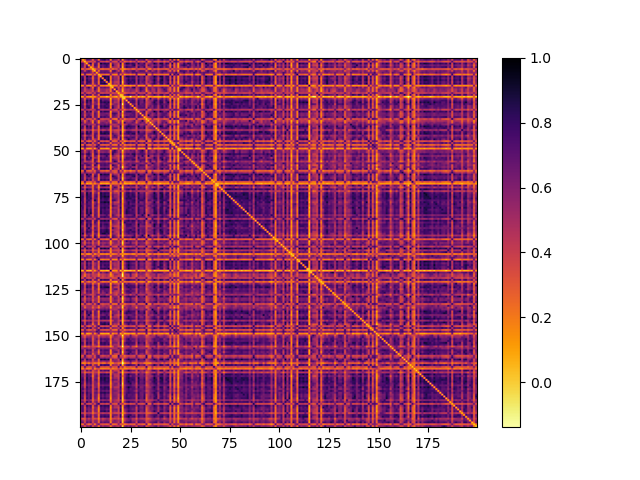

In [29]:
plt.close('all') 
plt.clf 

np.fill_diagonal(correlation_matrix, 0)
plt.imshow(correlation_matrix, aspect='auto',cmap='inferno_r',vmax = 1)
plt.colorbar()

In [30]:
# Added code (Michael)
# Draw Network in spring layout
# g_full = nx.DiGraph(correlation_matrix)
# fig = plt.figure(figsize=(16,16))
# t1 = fig.add_subplot(111)
# pos = nx.spring_layout(g_full,iterations=200,k=0.1)
# nx.draw_networkx_nodes(g_full,node_size=600, alpha=1.0,ax=t1,pos=pos)
# for edge in g_full.edges(data="weight"):
#     nx.draw_networkx_edges(g_full,pos=pos,edgelist=[edge], edge_color='grey',width=edge[2]*5,arrows=True,arrowsize=10,ax=t1,arrowstyle='fancy',connectionstyle= 'arc3,rad=0.2',alpha=0.1)


In [31]:
X = 1 - correlation_matrix
embedding = SpectralEmbedding(n_components=3)
X_transformed = embedding.fit_transform(X)
X_transformed.shape

(200, 3)

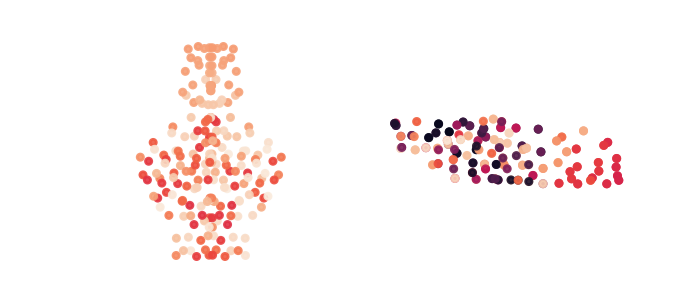

In [32]:
plt.close('all') 
plt.clf 


cplot =  np.empty((len(xx)))
cplot[:] = np.nan

f, axs = plt.subplots(1, 2, figsize=(7, 3))

#for c in range(2*nClus):
#    sub_ind = np.argwhere(indices==c) 
#    cplot[sub_ind] = X_transformed[c,0]

    
#axs[0].scatter(xx, yy,  lw=1, s=5, alpha = .05, c= cplot, cmap='inferno_r')

#axs[1].scatter(yy, -zz,  lw=1, s=5, alpha = .05, c=  cplot, cmap='inferno_r')
    
    
axs[0].scatter(LR_centers[:,0], LR_centers[:,1], lw=2, s=20, alpha = .9, c=X_transformed[:,2], vmax = 0.1, cmap='rocket_r')


axs[1].scatter(LR_centers[:,1], -LR_centers[:,2], lw=2, s=20,  alpha = .9, c=X_transformed[:,2], cmap='rocket_r')



for i in range(2):
    # axs[i].set_title(k)
    axs[i].axis("equal")
    axs[i].axis("off")
    
    
plt.show() 

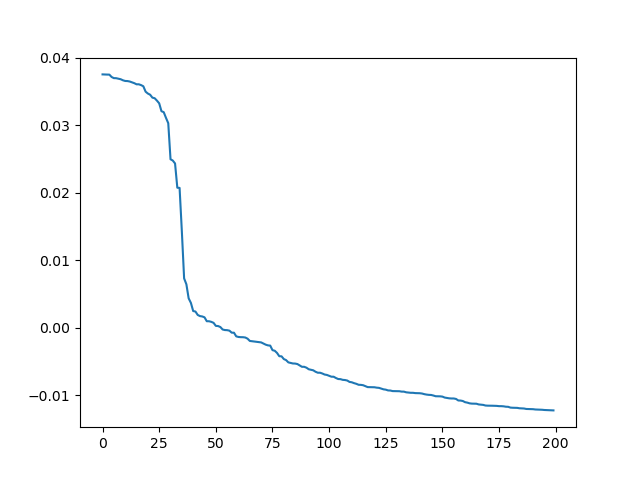

In [33]:
plt.close('all') 
plt.clf 

sort_ind = np.argsort(X_transformed[:,0])[::-1]

plt.plot(X_transformed[sort_ind,0])

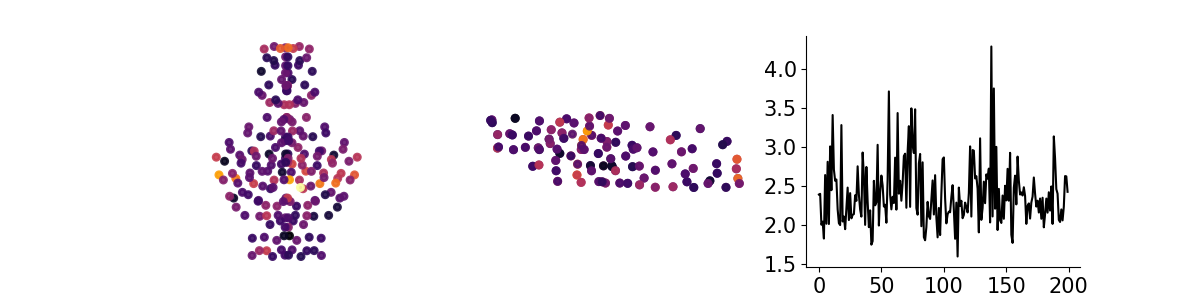

In [34]:
plt.close('all') 
plt.clf 

f, axs = plt.subplots(1, 3, figsize=(12, 3))


axs[0].scatter(LR_centers[:,0], LR_centers[:,1], lw=2, s=20, alpha = .9, c=All_Tau, cmap='inferno')


axs[1].scatter(LR_centers[:,1], -LR_centers[:,2], lw=2, s=20,  alpha = .9, c=All_Tau, cmap='inferno')

axs[2].plot(All_Tau[sort_ind],color = 'k')

axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


for i in range(2):
    # axs[i].set_title(k)
    axs[i].axis("equal")
    axs[i].axis("off")
    
    
plt.show() 

C:\Users\micha\AppData\Local\Temp\ipykernel_28096\276921876.py:39: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(cax)


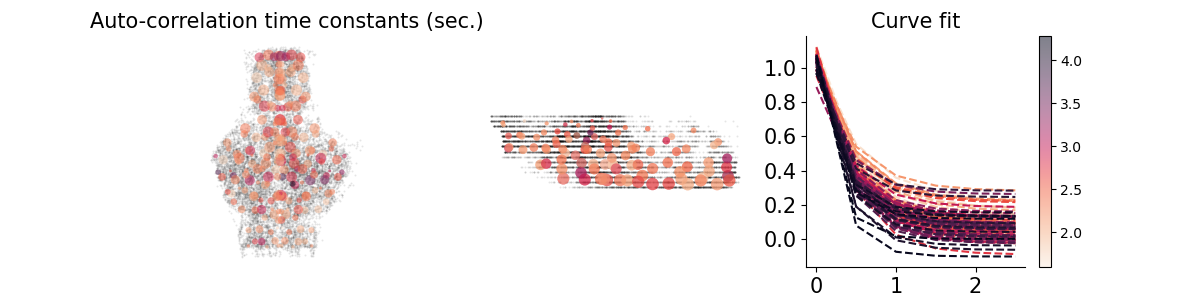

In [35]:
plt.close('all') 
plt.clf 

half_All_Tau = All_Tau[:nClus]
sort_Tau = np.argsort(half_All_Tau)
sorted_Tau = half_All_Tau[sort_Tau]
sorted_mag = All_mag[sort_Tau]
sorted_b = All_b[sort_Tau]


cmap = sns.color_palette("rocket_r", nClus)




fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].scatter(xx, yy, lw=0, s=2, alpha=0.1, color='k')
axs[1].scatter(yy, -zz, lw=0, s=2, alpha=0.1, color='k')


cax = axs[0].scatter(LR_centers[:,0], LR_centers[:,1], lw=0, s=.4*LR_centers[:,2], alpha = .5, c=All_Tau, cmap="rocket_r")

axs[0].set_title('Auto-correlation time constants (sec.)',fontsize=15)


axs[1].scatter(LR_centers[:,1], -LR_centers[:,2], lw=0, s=.5*LR_centers[:,2],  alpha = .5, c=All_Tau, cmap='rocket_r')


for c in range(nClus):
    axs[2].plot(xs[:6], monoExp(xs, sorted_mag[c] , sorted_Tau[c], sorted_b[c])[:6], '--', label="fitted", color = cmap[c] )

axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)

axs[2].set_title('Curve fit',fontsize=15)


cbar = fig.colorbar(cax)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


for i in range(2):
    # axs[i].set_title(k)
    axs[i].axis("equal")
    axs[i].axis("off")
    
    
plt.show() 



In [36]:
plt.style.use('default')
from statistics import variance

All_std =  np.empty((M_all.shape[1]))
All_std[:] = np.nan



for i in range(M_all.shape[1]):
    st =  variance(M_all[:,i])
    All_std[i] = st

    

C:\Users\micha\AppData\Local\Temp\ipykernel_28096\1827150968.py:20: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(cax)


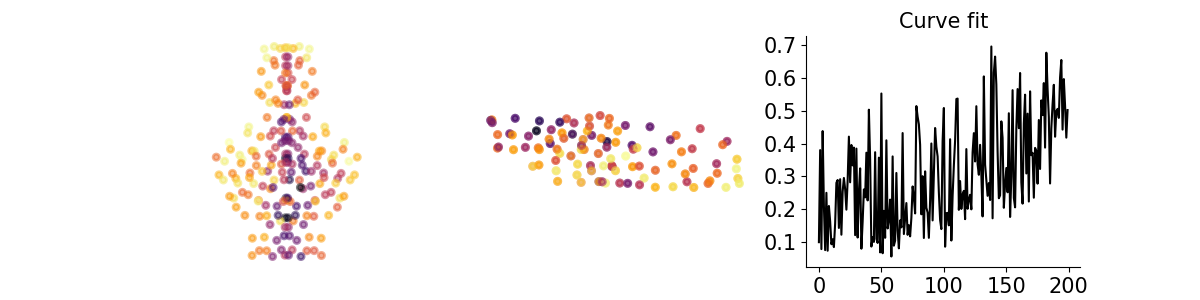

In [37]:
plt.close('all') 
plt.clf 

f, axs = plt.subplots(1, 3, figsize=(12, 3))

cax =  axs[0].scatter(LR_centers[:,0], LR_centers[:,1], lw=2, s=20, alpha = .5, c=All_std, cmap='inferno_r')


axs[1].scatter(LR_centers[:,1], -LR_centers[:,2], lw=2, s=20,  alpha = .5, c=All_std, cmap='inferno_r')

axs[2].plot(All_std[sort_ind],color = 'k')


axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)

axs[2].set_title('Curve fit',fontsize=15)


cbar = fig.colorbar(cax)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)



for i in range(2):
    # axs[i].set_title(k)
    axs[i].axis("equal")
    axs[i].axis("off")
    
    
plt.show() 

In [38]:
from scipy.stats import entropy


All_enp =  np.empty((M_all.shape[1]))
All_enp[:] = np.nan



for i in range(M_all.shape[1]):
    M = M_all[:,i]
    ep =  entropy(M + abs(min(M)), base=2)
    All_enp[i] = ep

    


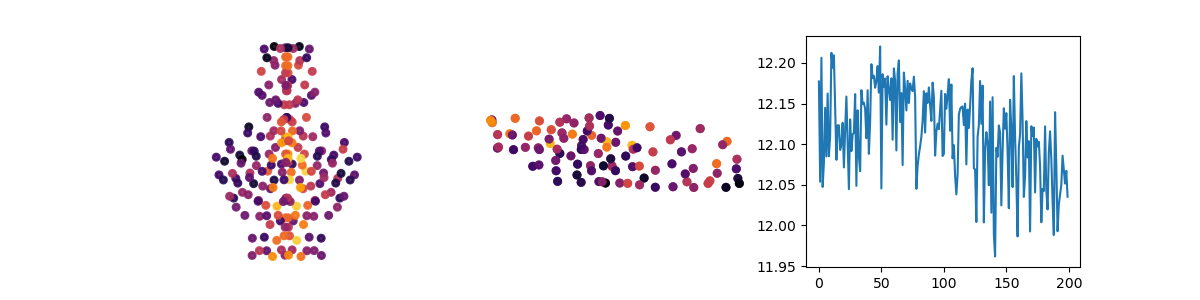

In [39]:
plt.close('all') 
plt.clf 

f, axs = plt.subplots(1, 3, figsize=(12, 3))



axs[0].scatter(LR_centers[:,0], LR_centers[:,1], lw=2, s=20, alpha = .9, c=All_enp, cmap='inferno_r')


axs[1].scatter(LR_centers[:,1], -LR_centers[:,2], lw=2, s=20,  alpha = .9, c=All_enp, cmap='inferno_r')

axs[2].plot(All_enp[sort_ind])



for i in range(2):
    # axs[i].set_title(k)
    axs[i].axis("equal")
    axs[i].axis("off")
    
    
plt.show() 

In [40]:

def num_zerocross(x, normalize=False, axis=-1):
    """Number of zero-crossings.
    .. versionadded: 0.1.3
    Parameters
    ----------
    x : list or np.array
        1D or N-D data.
    normalize : bool
        If True, divide by the number of samples to normalize the output
        between 0 and 1. Otherwise, return the absolute number of zero
        crossings.
    axis : int
        The axis along which to perform the computation. Default is -1 (last).
    Returns
    -------
    nzc : int or float
        Number of zero-crossings.
    Examples
  
    """
    x = np.asarray(x)
    # https://stackoverflow.com/a/29674950/10581531
    nzc = np.diff(np.signbit(x), axis=axis).sum(axis=axis)
    if normalize:
        nzc = nzc / x.shape[axis]
    return  nzc


def petrosian_fd(x, axis=-1):
    """Petrosian fractal dimension.

    Parameters
    ----------
    x : list or np.array
        1D or N-D data.
    axis : int
        The axis along which the FD is calculated. Default is -1 (last).

    Returns
    -------
    pfd : float
        Petrosian fractal dimension.

 
    """
    x = np.asarray(x)
    N = x.shape[axis]
    # Number of sign changes in the first derivative of the signal
    nzc_deriv = num_zerocross(np.diff(x, axis=axis), axis=axis)
    pfd = np.log10(N) / (np.log10(N) + np.log10(N / (N + 0.4 * nzc_deriv)))
    return pfd


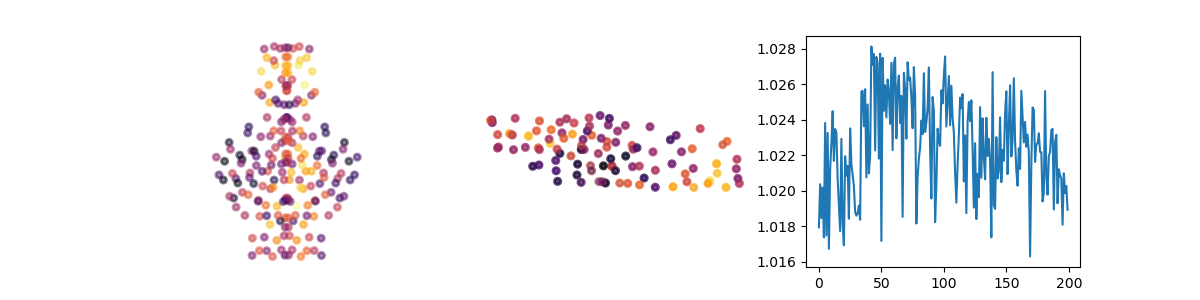

In [41]:
MPF=petrosian_fd(M_all, axis = 0)

plt.close('all') 
plt.clf 

f, axs = plt.subplots(1, 3, figsize=(12, 3))


axs[0].scatter(LR_centers[:,0], LR_centers[:,1], lw=2, s=20, alpha = .5, c=MPF, cmap='inferno_r')


axs[1].scatter(LR_centers[:,1], -LR_centers[:,2], lw=2, s=20,  alpha = .5, c=MPF, cmap='inferno_r')

axs[2].plot(MPF[sort_ind])



for i in range(2):
    # axs[i].set_title(k)
    axs[i].axis("equal")
    axs[i].axis("off")
    
    
plt.show() 

In [42]:
import nibabel as nib # git clone --branch enh/cifti2 https://github.com/satra/nibabel.git
from sklearn.metrics import pairwise_distances
from mapalign import embed



In [43]:
dcon =  np.tanh(correlation_matrix)

N = dcon.shape[0]

# Generate percentile thresholds for 90th percentile
perc = np.array([np.percentile(x, 95) for x in dcon])

# Threshold each row of the matrix by setting values below 90th percentile to 0
for i in range(dcon.shape[0]):
    dcon[i, dcon[i,:] < perc[i]] = 0    

In [44]:
# The negative values are very small, but we need to know how many nodes have negative values
# Count negative values per row
neg_values = np.array([sum(dcon[i,:] < 0) for i in range(N)])

# Since there are only 23 vertices with total of 5000 very small negative values, we set these to zero
dcon[dcon < 0] = 0

In [45]:

aff = 1 - pairwise_distances(dcon, metric = 'cosine')

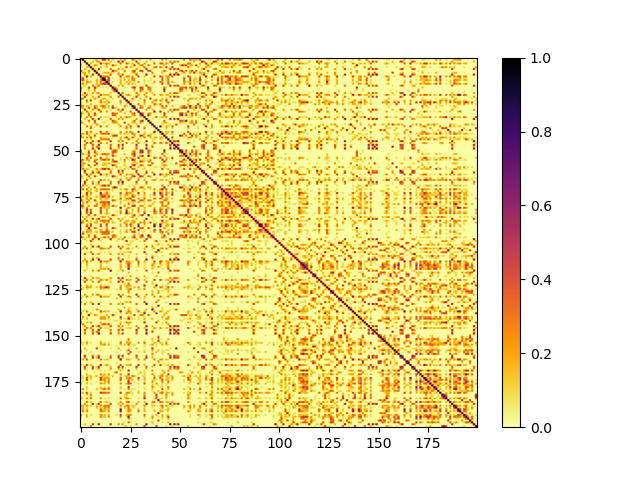

In [46]:
plt.close('all') 
plt.clf 


#np.fill_diagonal(correlation_matrix, 0)

plt.imshow(aff, aspect='auto',cmap='inferno_r',vmax = 1)
plt.colorbar()

In [47]:
embedding = SpectralEmbedding(n_components=3)
X_transformed = embedding.fit_transform(aff)
X_transformed.shape

(200, 3)

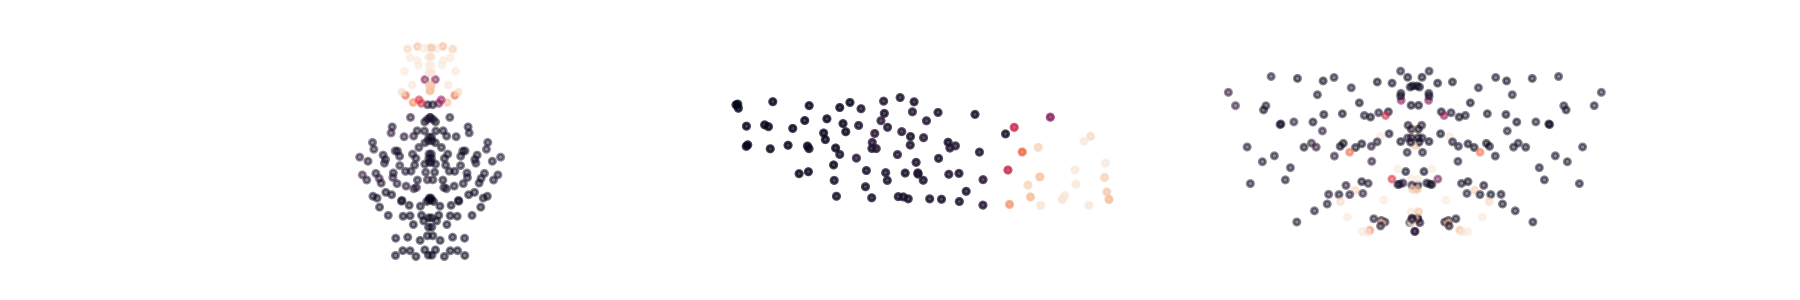

In [48]:
plt.close('all') 
plt.clf 


cplot =  np.empty((len(xx)))
cplot[:] = np.nan

f, axs = plt.subplots(1, 3, figsize=(18, 3))

#for c in range(2*nClus):
#    sub_ind = np.argwhere(indices==c) 
#    cplot[sub_ind] = X_transformed[c,0]

    
#axs[0].scatter(xx, yy,  lw=1, s=5, alpha = .05, c= cplot, cmap='inferno_r')

#axs[1].scatter(yy, -zz,  lw=1, s=5, alpha = .05, c=  cplot, cmap='inferno_r')
    
    
axs[0].scatter(LR_centers[:,0], LR_centers[:,1], lw=2, s=20, alpha = .5, c=X_transformed[:,0], cmap='rocket')


axs[1].scatter(LR_centers[:,1], -LR_centers[:,2], lw=2, s=20,  alpha = .5, c=X_transformed[:,0], cmap='rocket')

axs[2].scatter(LR_centers[:,0], -LR_centers[:,2], lw=2, s=20,  alpha = .5, c=X_transformed[:,0], cmap='rocket')


for i in range(3):
    # axs[i].set_title(k)
    axs[i].axis("equal")
    axs[i].axis("off")
    
    
plt.show() 

ValueError: 'c' argument has 200 elements, which is inconsistent with 'x' and 'y' with size 12964.

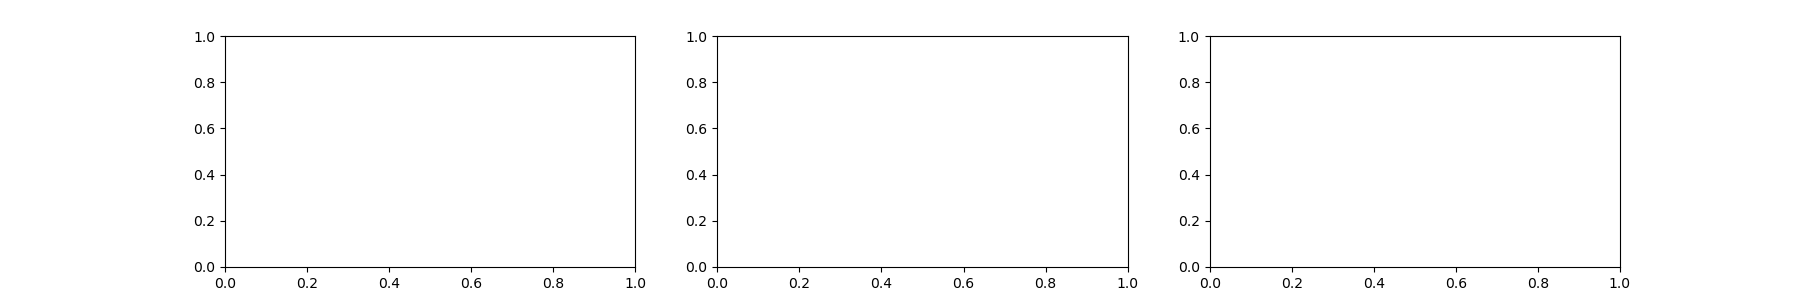

In [49]:
plt.close('all') 
plt.clf 


cplot =  np.empty((len(xx)))
cplot[:] = np.nan

f, axs = plt.subplots(1, 3, figsize=(18, 3))


    
axs[0].scatter(xx, yy,  lw=1, s=5, alpha = .03, c= X_transformed[:,2], cmap='rocket')

axs[1].scatter(yy, -zz,  lw=1, s=5, alpha = .03, c=  X_transformed[:,2], cmap='rocket')
    
    



for i in range(3):
    # axs[i].set_title(k)
    axs[i].axis("equal")
    axs[i].axis("off")
    
    
plt.show() 

In [ ]:
ac=sm.tsa.acf(TC[:,10])
ac_len = len(ac)

sampleRate = 2

AC_all = np.empty((len(ac),TC.shape[1]))
AC_all[:] = np.nan
xs = (1 / sampleRate)*np.arange(ac_len)

All_Tau =  np.empty((TC.shape[1]))
All_Tau[:] = np.nan

All_mag =  np.empty((TC.shape[1]))
All_mag[:] = np.nan

All_b =  np.empty((TC.shape[1]))
All_b[:] = np.nan


def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

p0 = (1, .1, 0) # start with values near those we expect


for i in range(TC.shape[1]):
    ys =  sm.tsa.acf(TC[:,i])
    AC_all[:,i] = ys
    params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
    m, t, b = params
    tauSec = (1 / t) / sampleRate
    All_Tau[i] = tauSec
    All_mag[i] = m
    All_b[i] = b

    
    



In [ ]:
i

22196

In [ ]:
TC.shape[1]

22871

In [ ]:
plt.close('all') 
plt.clf 


cplot =  np.empty((len(xx)))
cplot[:] = np.nan

f, axs = plt.subplots(1, 3, figsize=(18, 3))


    
axs[0].scatter(xx, yy,  lw=1, s=5, alpha = .03, c=All_Tau, cmap='rocket')

axs[1].scatter(yy, -zz,  lw=1, s=5, alpha = .03, c=  All_Tau, cmap='rocket')
    
    



for i in range(3):
    # axs[i].set_title(k)
    axs[i].axis("equal")
    axs[i].axis("off")
    
    
plt.show() 

NameError: name 'plt' is not defined